In [1]:
from sklearn.metrics import mean_squared_error as MSE
from common import *
from models import *

2021-12-17 19:19:00.377372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 19:19:00.377420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")
print(df.shape)
price = df['NO2_price'].values.reshape(-1,1)
print(price.shape)

(51648, 20)
(51648, 1)


In [3]:
#days = seperate_column_to_days(df['NO2_price'])
scaler = MinMaxScaler()
price = scaler.fit_transform(price)
print(price.shape)

(51648, 1)


# Creating datasets of days
What I want is to create individual sequences of days, the idea is to use 72 hours to create 3 days, which can then be used to predict further on in time

In [4]:
lookbehind = 3
horizon = 24
no_hours = lookbehind*24 + horizon# lookbehind + one horizon
#hour_in_days = int(no_hours / 24)

print(price.shape)
print(price[::24].shape)
price_dataset = []
for i in range(0,len(price)-72,24):
    price_dataset.append(price[i:i+no_hours])

price_dataset = np.array(price_dataset)
print(price_dataset.shape)

(51648, 1)
(2152, 1)
(2149, 96, 1)


In [5]:
#scaler = MinMaxScaler()
#dataset = scaler.fit_transform(dataset)
#dataset = dataset[..., np.newaxis].astype(np.float32)

n,m,k = price_dataset.shape
print(n,m,k)

n_steps = m - 24
horizon = 24

2149 96 1


In [6]:
train = int(0.7*n)
valid = int(0.9*n)
#train = int(0.9*n)

# (7000 time series, 50 steps each)
X_train, y_train = price_dataset[:train, :n_steps], price_dataset[:train, -horizon:, 0]
X_valid, y_valid = price_dataset[train:valid, :n_steps], price_dataset[train:valid, -horizon: 0]
X_test, y_test = price_dataset[valid:, :n_steps], price_dataset[valid:, -horizon:, 0]
#X_test, y_test = price_dataset[train:, :n_steps], price_dataset[train:, -horizon:, 0]


# Seq - to - seq does not give satisfying results

Y = np.empty((n, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = price_dataset[:,step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]


print(f"{X_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{X_test.shape=}")

print(f"{Y_train.shape=}")
print(f"{Y_valid.shape=}")
print(f"{Y_test.shape=}")

X_train.shape=(1504, 72, 1)
X_valid.shape=(430, 72, 1)
X_test.shape=(215, 72, 1)
Y_train.shape=(1504, 72, 24)
Y_valid.shape=(430, 72, 24)
Y_test.shape=(215, 72, 24)


In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])


model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20)),
    keras.layers.Dense(horizon)
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(horizon)
])

"""
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])
"""

In [ ]:
model.summary()
model_ln.summary()
model_lstm.summary()
#model_gru.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 10
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_ln.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
#model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
history_ln = model_ln.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
#history_gru = model_gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(y_test.shape)
print(y_pred.shape)

print(MSE(y_test[:], y_pred[:]))

In [ ]:
y_pred_ln = model_ln.predict(X_test)

In [ ]:
print(MSE(y_test[:], y_pred))

In [ ]:
y_pred_lstm = model_lstm.predict(X_test)

In [ ]:
print(MSE(y_test, y_pred_lstm))

# Sequence to vector, with 24 outputs at final timestep

In [ ]:
x = np.arange(no_hours)
plt.figure(figsize=(15,10))
plt.plot(x[:no_hours-horizon], X_test[35,:].flatten(), '.-')
plt.plot(x[-horizon:], y_test[35].flatten(), '.-', label="TrueSol")
plt.plot(x[-horizon:], y_pred[35].flatten(), '-.', label="SimpleRNN")
#plt.plot(x[-horizon:], y_pred_ln[35].flatten(), '-.', label="LayerNorm")
plt.plot(x[-horizon:], y_pred_lstm[35].flatten(), '-.', label="LSTM")
plt.legend()
plt.grid()
plt.show()

# SEQ to SEQ plots
These are now corrected

In [7]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.SimpleRNN(128, return_sequences=True),
    #keras.layers.SimpleRNN(128, return_sequences=True),
    #keras.layers.SimpleRNN(128, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.LSTM(128, return_sequences=True),
    #keras.layers.LSTM(128, return_sequences=True),
    #keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

model_gru = keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=3, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(128, return_sequences=True),
    #keras.layers.GRU(128, return_sequences=True),
    #keras.layers.GRU(32, return_sequences=True),
    #keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dense(horizon)#, activation='leaky_relu')
])

2021-12-17 19:19:11.448682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-17 19:19:11.448881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 19:19:11.449281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-17 19:19:11.449362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-17 19:19:11.449419: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 25
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [9]:
model.summary()
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 128)         16640     
                                                                 
 dense (Dense)               (None, None, 24)          3096      
                                                                 
Total params: 19,736
Trainable params: 19,736
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         66560     
                                                                 
 dense_1 (Dense)             (None, None, 24)          3096      
                                                                 
Total params: 69,656
Trainable

In [10]:

history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/25
47/47 [==============================] - 2s 23ms/step - loss: 0.0314 - last_time_step_mse: 0.1295 - val_loss: 0.0070 - val_last_time_step_mse: 0.0690
Epoch 2/25
47/47 [==============================] - 1s 20ms/step - loss: 0.0013 - last_time_step_mse: 0.0265 - val_loss: 0.0042 - val_last_time_step_mse: 0.0550
Epoch 3/25
47/47 [==============================] - 1s 19ms/step - loss: 7.2937e-04 - last_time_step_mse: 0.0187 - val_loss: 0.0017 - val_last_time_step_mse: 0.0298
Epoch 4/25
47/47 [==============================] - 1s 23ms/step - loss: 3.7183e-04 - last_time_step_mse: 0.0110 - val_loss: 8.5411e-04 - val_last_time_step_mse: 0.0131
Epoch 5/25
47/47 [==============================] - 1s 24ms/step - loss: 3.4286e-04 - last_time_step_mse: 0.0109 - val_loss: 8.0326e-04 - val_last_time_step_mse: 0.0151
Epoch 6/25
47/47 [==============================] - 1s 23ms/step - loss: 2.9033e-04 - last_time_step_mse: 0.0094 - val_loss: 7.5188e-04 - val_last_time_step_mse: 0.0130
Epoch 

In [11]:
history_lstm = model_lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/25
47/47 [==============================] - 4s 57ms/step - loss: 0.0093 - last_time_step_mse: 0.0622 - val_loss: 0.0057 - val_last_time_step_mse: 0.0660
Epoch 2/25
47/47 [==============================] - 2s 45ms/step - loss: 9.7737e-04 - last_time_step_mse: 0.0228 - val_loss: 0.0028 - val_last_time_step_mse: 0.0438
Epoch 3/25
47/47 [==============================] - 2s 51ms/step - loss: 3.5768e-04 - last_time_step_mse: 0.0110 - val_loss: 7.8252e-04 - val_last_time_step_mse: 0.0134
Epoch 4/25
47/47 [==============================] - 2s 44ms/step - loss: 2.7774e-04 - last_time_step_mse: 0.0088 - val_loss: 7.4860e-04 - val_last_time_step_mse: 0.0134
Epoch 5/25
47/47 [==============================] - 2s 48ms/step - loss: 2.6737e-04 - last_time_step_mse: 0.0087 - val_loss: 7.3504e-04 - val_last_time_step_mse: 0.0133
Epoch 6/25
47/47 [==============================] - 2s 46ms/step - loss: 2.6147e-04 - last_time_step_mse: 0.0086 - val_loss: 7.0980e-04 - val_last_time_step_mse: 0.012

In [12]:
history_gru = model_gru.fit(X_train, Y_train[:,2::3], epochs=epochs, validation_data=(X_valid, Y_valid[:,2::3]))

Epoch 1/25
47/47 [==============================] - 2s 22ms/step - loss: 0.0389 - last_time_step_mse: 0.1020 - val_loss: 0.0017 - val_last_time_step_mse: 0.0319
Epoch 2/25
47/47 [==============================] - 1s 15ms/step - loss: 4.0717e-04 - last_time_step_mse: 0.0131 - val_loss: 7.9831e-04 - val_last_time_step_mse: 0.0161
Epoch 3/25
47/47 [==============================] - 1s 15ms/step - loss: 3.1048e-04 - last_time_step_mse: 0.0110 - val_loss: 6.4535e-04 - val_last_time_step_mse: 0.0126
Epoch 4/25
47/47 [==============================] - 1s 15ms/step - loss: 2.8063e-04 - last_time_step_mse: 0.0099 - val_loss: 8.6217e-04 - val_last_time_step_mse: 0.0199
Epoch 5/25
47/47 [==============================] - 1s 14ms/step - loss: 2.8451e-04 - last_time_step_mse: 0.0104 - val_loss: 6.2410e-04 - val_last_time_step_mse: 0.0129
Epoch 6/25
47/47 [==============================] - 1s 16ms/step - loss: 2.7076e-04 - last_time_step_mse: 0.0099 - val_loss: 6.0066e-04 - val_last_time_step_mse: 0

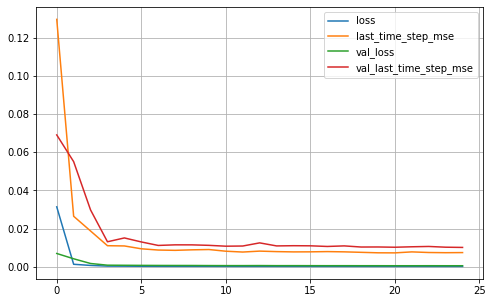

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

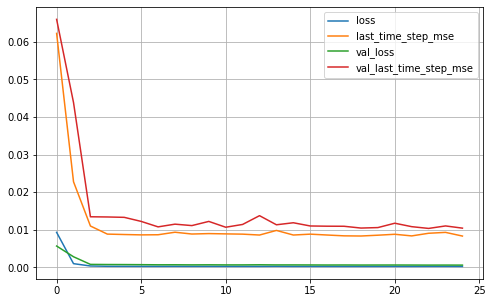

In [14]:
pd.DataFrame(history_lstm.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

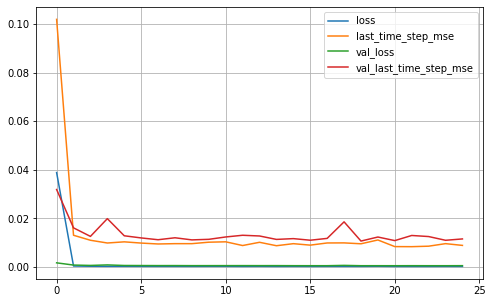

In [15]:
pd.DataFrame(history_gru.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [16]:
Y_pred = model.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
Y_pred_gru = model_gru.predict(X_test)

In [17]:
print(f"{MSE(Y_test[:,-1], Y_pred[:,-1])=}")
print(f"{MSE(Y_test[:,-1], Y_pred_lstm[:,-1])=}")
print(f"{MSE(Y_test[:,-1], Y_pred_gru[:,-1])=}")

MSE(Y_test[:,-1], Y_pred[:,-1])=0.002610241840164411
MSE(Y_test[:,-1], Y_pred_lstm[:,-1])=0.0028652435172344393
MSE(Y_test[:,-1], Y_pred_gru[:,-1])=0.002957303715375415


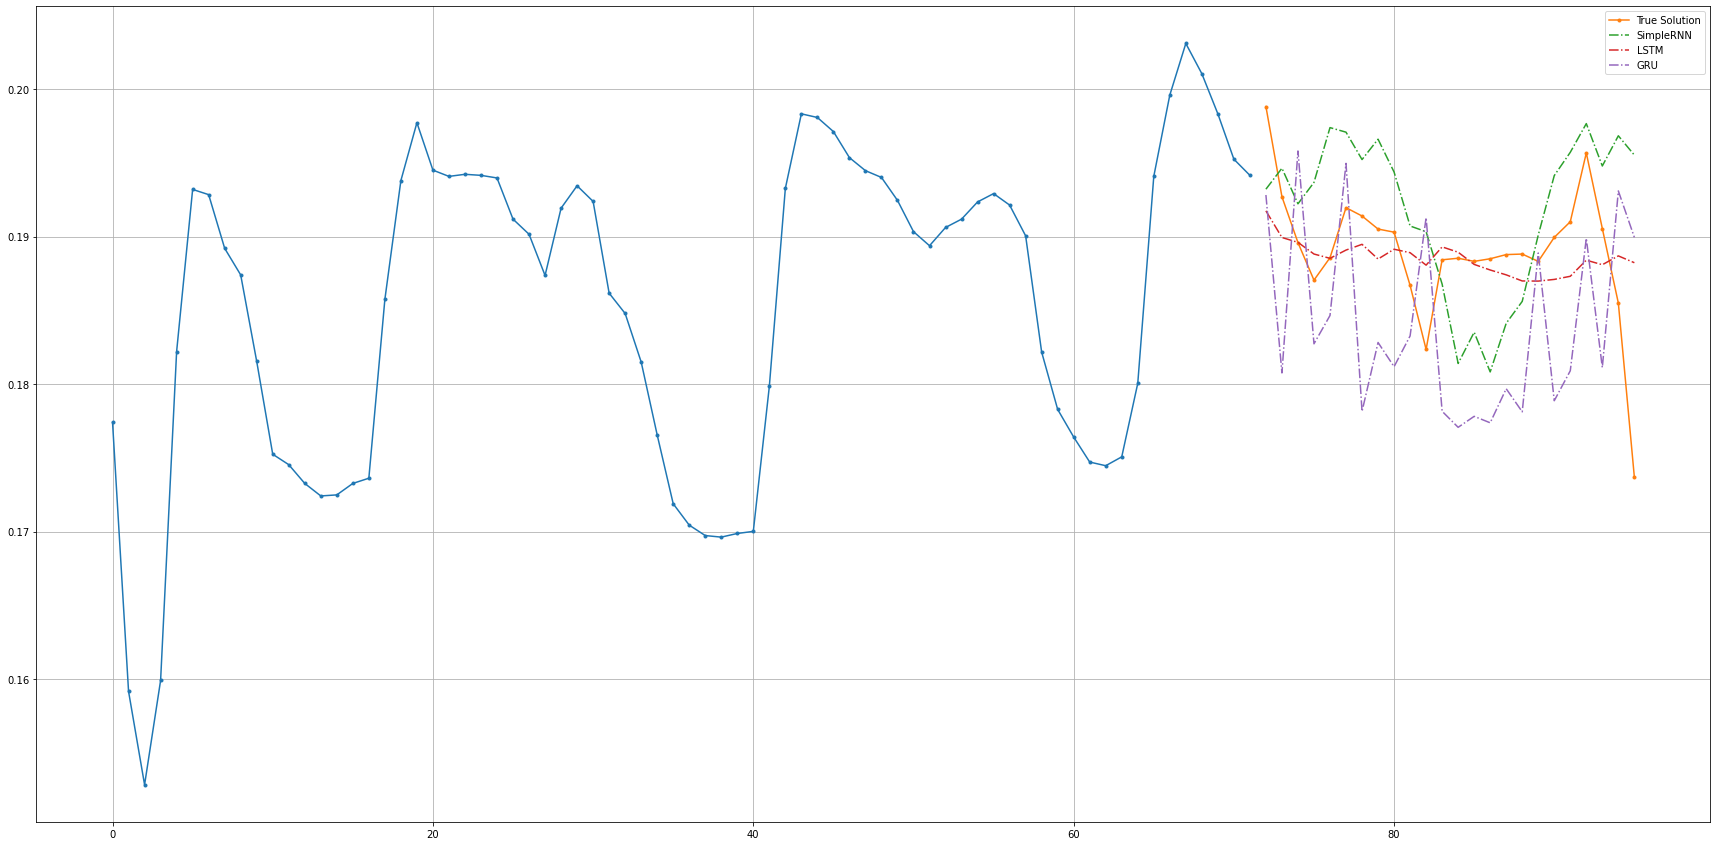

In [28]:
x = np.arange(no_hours)
plt.figure(figsize=(30,15))
plt.plot(x[:no_hours-horizon], X_test[35,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_test[35,-1].flatten(), '.-', label="True Solution")
#plt.plot(x[24:], X_test[37,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_pred[35,-1].flatten(), '-.', label="SimpleRNN")
plt.plot(x[-horizon:], Y_pred_lstm[35,-1].flatten(), '-.', label="LSTM")
plt.plot(x[-horizon:], Y_pred_gru[35,-1].flatten(), '-.', label="GRU")
plt.legend()
plt.grid()
plt.show()

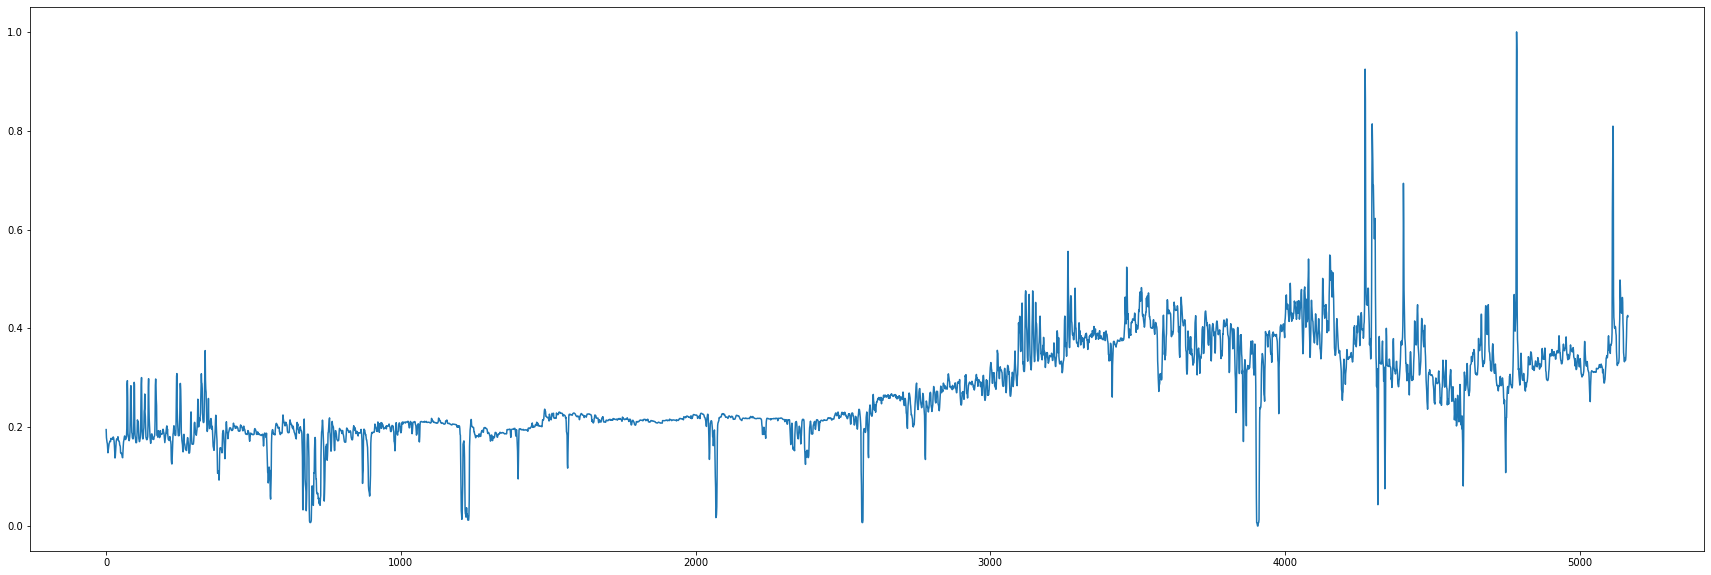

In [19]:
plt.figure(figsize=(30,10))
plt.plot(price[int(len(price)*0.9):])

In [20]:
print(X_train.shape)

(1504, 72, 1)


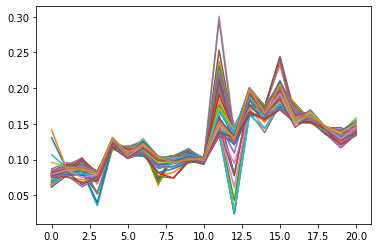

In [21]:
plt.plot(X_train[::72,:,0])

In [22]:
"""
Y_pred = model.predict(X_test)
Y_pred_ln = model_ln.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
#Y_pred_gru = model_gru.predict(X_test)
"""

'\nY_pred = model.predict(X_test)\nY_pred_ln = model_ln.predict(X_test)\nY_pred_lstm = model_lstm.predict(X_test)\n#Y_pred_gru = model_gru.predict(X_test)\n'

In [23]:
"""
sequence = np.concatenate((X_test[0].flatten(), Y_pred[0,-1,:].flatten()))
sequence_ln = np.concatenate((X_test[0].flatten(), Y_pred_ln[0,-1,:].flatten()))
sequence_lstm = np.concatenate((X_test[0].flatten(), Y_pred_lstm[0,-1,:].flatten()))
#sequence_gru = np.concatenate((X_test[20].flatten(), Y_pred_gru[20,-horizon:,-1].flatten()))

x = np.arange(n_steps + horizon)
plt.figure(figsize=(15,10))
plt.plot(x[:n_steps], sequence[:n_steps], '.-')
plt.plot(x[n_steps-1:], sequence[n_steps-1:], '-.', label="SimpleRNN")
plt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], '-.', label="Layer norm")
plt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], '-.', label="LSTM")
#plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], '-.', label="GRU")

plt.legend()
plt.grid()
plt.show()
"""

'\nsequence = np.concatenate((X_test[0].flatten(), Y_pred[0,-1,:].flatten()))\nsequence_ln = np.concatenate((X_test[0].flatten(), Y_pred_ln[0,-1,:].flatten()))\nsequence_lstm = np.concatenate((X_test[0].flatten(), Y_pred_lstm[0,-1,:].flatten()))\n#sequence_gru = np.concatenate((X_test[20].flatten(), Y_pred_gru[20,-horizon:,-1].flatten()))\n\nx = np.arange(n_steps + horizon)\nplt.figure(figsize=(15,10))\nplt.plot(x[:n_steps], sequence[:n_steps], \'.-\')\nplt.plot(x[n_steps-1:], sequence[n_steps-1:], \'-.\', label="SimpleRNN")\nplt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], \'-.\', label="Layer norm")\nplt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], \'-.\', label="LSTM")\n#plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], \'-.\', label="GRU")\n\nplt.legend()\nplt.grid()\nplt.show()\n'

In [24]:
"""
fig = plt.figure()
x = np.arange(5*24)
plt.plot(x[:72],dataset[0],'--')
plt.plot(x[24:4*24],dataset[1],'--')
plt.plot(x[2*24:5*24],dataset[2],'--')
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show
"""

'\nfig = plt.figure()\nx = np.arange(5*24)\nplt.plot(x[:72],dataset[0],\'--\')\nplt.plot(x[24:4*24],dataset[1],\'--\')\nplt.plot(x[2*24:5*24],dataset[2],\'--\')\nplt.xlabel("time")\nplt.ylabel("price")\nplt.grid()\nplt.show\n'